# Intro

## Importing Libraries

In [36]:
import pandas as pd
import json
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import re
import string
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from copy import deepcopy
# I have written this processor similar to HW3 steps
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

## GPT-5 Prompting and Data Expansion

In [2]:
# GPT-5 Prompt to get all crime words
'''

For each of the following crimes, give me a list of relevant words related to that crime.
The goal is that, given a crime, I will be able to search these words in a comment so that I know
whether that comment is talking about that crime. Your output should be a dictionary of lists such that each of
the following crimes is a key and its relevant words are values. Each related crime should be one word, not more.
Also consider other derivations; for instance, you should consider 'robbed' for 'robbery' as well:



['theft' 'battery' 'other offense' 'burglary' 'criminal trespass'
 'robbery' 'assault' 'deceptive practice' 'narcotics' 'criminal damage'
 'motor vehicle theft' 'prostitution' 'weapons violation' 'kidnapping'
 'offense involving children' 'sex offense'
 'interference with public officer' 'liquor law violation'
 'criminal sexual assault' 'public peace violation' 'stalking'
 'crim sexual assault' 'homicide' 'arson'
 'concealed carry license violation' 'gambling' 'obscenity'
 'public indecency' 'intimidation' 'human trafficking'
 'other narcotic violation' 'non-criminal' 'ritualism']

'''

"\n\nFor each of the following crimes, give me a list of relevant words related to that crime.\nThe goal is that, given a crime, I will be able to search these words in a comment so that I know\nwhether that comment is talking about that crime. Your output should be a dictionary of lists such that each of\nthe following crimes is a key and its relevant words are values. Each related crime should be one word, not more.\nAlso consider other derivations; for instance, you should consider 'robbed' for 'robbery' as well:\n\n\n\n['theft' 'battery' 'other offense' 'burglary' 'criminal trespass'\n 'robbery' 'assault' 'deceptive practice' 'narcotics' 'criminal damage'\n 'motor vehicle theft' 'prostitution' 'weapons violation' 'kidnapping'\n 'offense involving children' 'sex offense'\n 'interference with public officer' 'liquor law violation'\n 'criminal sexual assault' 'public peace violation' 'stalking'\n 'crim sexual assault' 'homicide' 'arson'\n 'concealed carry license violation' 'gambling'

In [3]:
all_crime_words_dict = {
"theft": ["theft", "steal", "stole", "stolen", "stealing", "thief", "larceny", "shoplifting", "shoplifter", "pickpocket", "pilfer", "pilfered", "snatch", "snatched", "swipe", "swiped", "loot", "looted", "boosted"],
"battery": ["battery", "battered", "beating", "beat", "beaten", "hit", "hits", "hitting", "punch", "punched", "slap", "slapped", "struck", "kick", "kicked", "kicking", "bruised", "choked", "choking"],
"other offense": ["offense", "violation", "infraction", "misconduct", "nuisance", "noncompliance", "breach", "contravention", "offending", "violate"],
"burglary": ["burglary", "burglar", "burglarized", "burglarize", "burgled", "housebreaking", "prowler", "prowling", "ransacked", "pried", "intruder", "forced"],
"criminal trespass": ["trespass", "trespassed", "trespassing", "intrusion", "intruder", "encroached", "encroaching", "unauthorized", "loitering", "squatting", "squatter"],
"robbery": ["robbery", "rob", "robbed", "robbing", "robber", "robbers", "mugging", "mugged", "mugger", "holdup", "heist", "stickup", "carjacking", "carjacked", "snatch", "snatched"],
"assault": ["assault", "assaulted", "assaulting", "attack", "attacked", "attacker", "threat", "threats", "threatened", "menace", "menacing", "struck", "hit", "punch"],
"deceptive practice": ["fraud", "frauds", "fraudulent", "scam", "scams", "scammed", "scamming", "swindle", "swindled", "cheat", "cheated", "cheating", "forgery", "forgeries", "counterfeit", "counterfeits", "phishing", "spoofing", "skimming", "impersonation", "embezzlement"],
"narcotics": ["narcotics", "drug", "drugs", "heroin", "cocaine", "crack", "opioid", "opioids", "fentanyl", "meth", "methamphetamine", "marijuana", "cannabis", "weed", "xanax", "oxycontin", "percocet", "ketamine", "ecstasy", "mdma", "lsd", "possession", "distribution", "dealing", "dealer", "trafficking", "stash"],
"criminal damage": ["vandalism", "vandalized", "graffiti", "damage", "damaged", "destroy", "destroyed", "destruction", "smash", "smashed", "deface", "defaced", "breakage", "sabotage", "tampering", "shattered", "keyed"],
"motor vehicle theft": ["stolen", "stole", "carjacking", "carjacked", "joyride", "joyriding", "hotwire", "hotwired", "boosted", "hijack", "hijacked"],
"prostitution": ["prostitution", "prostitute", "escorting", "escort", "solicitation", "solicit", "solicited", "pimp", "pimping", "john", "brothel", "madam", "sexwork"],
"weapons violation": ["gun", "guns", "firearm", "firearms", "pistol", "revolver", "rifle", "shotgun", "ammo", "ammunition", "magazine", "silencer", "switchblade", "knife", "blade", "brandishing", "discharge", "unlawful", "concealed", "possession"],
"kidnapping": ["kidnapping", "kidnap", "kidnapped", "abduct", "abducted", "abduction", "hostage", "snatched", "seized", "ransom"],
"offense involving children": ["endangerment", "neglect", "abuse", "abused", "abusive", "exploitation", "grooming", "molestation", "runaway", "custody", "truancy"],
"sex offense": ["molestation", "molested", "groping", "groped", "indecency", "lewdness", "exposure", "voyeurism", "voyeur", "peeping", "flashing", "fondling", "sodomy"],
"interference with public officer": ["obstruction", "obstructing", "resisting", "resisted", "impeding", "hindering", "interference", "fleeing", "eluding", "evading", "assaulting", "battering", "bribery", "tampering", "harassing"],
"liquor law violation": ["alcohol", "liquor", "beer", "wine", "spirits", "intoxicated", "drunk", "drinking", "bootlegging", "moonshine", "underage", "bar", "tavern"],
"criminal sexual assault": ["rape", "raped", "rapist", "raping", "forcible", "nonconsensual", "assault", "penetration", "coercion"],
"public peace violation": ["disorderly", "disturbance", "disturbing", "riot", "rioting", "affray", "brawl", "brawling", "loitering", "noise", "nuisance", "fighting", "uproar"],
"stalking": ["stalking", "stalker", "stalked", "harassing", "harassment", "following", "shadowing", "cyberstalking", "obsessed", "tailing"],
"crim sexual assault": ["rape", "raped", "rapist", "raping", "forcible", "nonconsensual", "assault", "penetration", "coercion"],
"homicide": ["homicide", "homicides", "homicidal", "murder", "murdered", "murderer", "killing", "killed", "slaying", "manslaughter"],
"arson": ["arson", "arsonist", "burning", "ignited", "torch", "torched", "incendiary", "fire"],
"concealed carry license violation": ["concealed", "carry", "license", "permit", "revoked", "revocation", "suspended", "violation", "unlicensed", "holster", "expired", "foid"],
"gambling": ["gambling", "gamble", "gambled", "bet", "bets", "betting", "wager", "wagers", "bookie", "bookmaking", "poker", "roulette", "blackjack", "casino", "lottery", "slots"],
"obscenity": ["obscenity", "obscene", "porn", "pornography", "smut", "indecent", "lewd", "vulgarity", "profane", "profanity"],
"public indecency": ["indecency", "indecent", "nudity", "nude", "exposure", "exposed", "lewdness", "flashing", "streaking", "urination", "urinated"],
"intimidation": ["intimidation", "intimidate", "threat", "threats", "threaten", "threatened", "coerce", "coercion", "menace", "menacing", "extort", "extortion", "blackmail"],
"human trafficking": ["trafficking", "trafficked", "smuggling", "smuggled", "exploitation", "exploited", "coercion", "forced", "bondage", "labor", "transport", "recruitment"],
"other narcotic violation": ["paraphernalia", "syringe", "syringes", "needle", "needles", "baggie", "contraband", "illicit", "possession", "pills", "capsules"],
"non-criminal": ["civil", "information", "found", "lost", "assist", "welfare", "accident", "medical"],
"ritualism": ["ritualism", "ritual", "occult", "ceremony", "ceremonial", "sacrifice", "sacrificial", "cult", "satanic", "witchcraft"]
}

reverse_subcrime_2_crime = {sub_crime: k for k, v in all_crime_words_dict.items() for sub_crime in v}
all_crime_words = [word for _, values in all_crime_words_dict.items() for word in values]
main_crimes_importances = {k: 0 for k, v in all_crime_words_dict.items()}

## Reading Data and Defining Functions

In [5]:
crime_dataset_path = 'drive/MyDrive/CS418_CLEAN_DATA/crime_dataset.csv'
divvy_dataset_path = 'drive/MyDrive/CS418_CLEAN_DATA/divvy_dataset.csv'
event_dataset_path = 'drive/MyDrive/CS418_CLEAN_DATA/event_dataset.csv'
station_dataset_path = 'drive/MyDrive/CS418_CLEAN_DATA/train_dataset.csv'
park_path = 'drive/MyDrive/CS418_CLEAN_DATA/parks_reviews.json'

crime_data = pd.read_csv(crime_dataset_path)
divvy_data = pd.read_csv(divvy_dataset_path)
event_data = pd.read_csv(event_dataset_path)
station_data = pd.read_csv(station_dataset_path)

with open(park_path, 'r') as f:
  parks = json.load(f)

In [7]:
crime_data

,date,block,primary type,description,location description,arrest,domestic,beat,district,community area,fbi code,x coordinate,y coordinate,year,latitude,longitude,location,neighborhood
0,2023-06-19 22:30:00,080xx s champlain ave,theft,$500 and under,apartment,False,False,631,6.0,44.0,06,1181960.0,1851868.0,2023,41.748750,-87.608803,"(41.748750204, -87.608802927)",chatham
1,2014-11-05 12:50:00,034xx n western ave,theft,retail theft,grocery food store,True,False,1921,19.0,5.0,06,1159771.0,1922681.0,2014,41.943553,-87.688162,"(41.943552694, -87.688162342)",north center
2,2024-04-21 21:00:00,035xx w flournoy st,battery,domestic battery simple,apartment,False,True,1133,11.0,27.0,08b,1152924.0,1896804.0,2024,41.872682,-87.714015,"(41.872682495, -87.714015459)",garfield park
3,2022-03-13 13:30:00,019xx w superior st,other offense,telephone threat,apartment,False,True,1221,12.0,24.0,08a,1163421.0,1905023.0,2022,41.895022,-87.675245,"(41.895021814, -87.675244755)",west town
4,2025-03-07 03:08:00,009xx n monticello ave,burglary,forcible entry,residence,True,False,1112,11.0,23.0,05,1151875.0,1906073.0,2025,41.898138,-87.717623,"(41.898138305, -87.717622673)",humboldt park
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890429,2019-05-06 03:00:00,061xx n winthrop ave,criminal damage,to property,apartment,False,False,2433,24.0,77.0,14,1167753.0,1940728.0,2019,41.992906,-87.658302,"(41.992905649, -87.658301822)",edgewater
2890430,2015-03-02 09:30:00,044xx s drake ave,theft,$500 and under,residential yard (front/back),False,False,821,8.0,58.0,06,1153476.0,1874962.0,2015,41.812734,-87.712568,"(41.812734431, -87.712568416)",brighton park
2890431,2014-11-12 13:36:00,001xx s hamlin blvd,battery,domestic battery simple,residence,False,True,1122,11.0,26.0,08b,1151097.0,1898922.0,2014,41.878530,-87.720668,"(41.878530499, -87.720667749)",garfield park
2890432,2022-04-04 17:30:00,015xx e 74th pl,battery,domestic battery simple,apartment,False,True,324,3.0,43.0,08b,1187742.0,1855895.0,2022,41.759665,-87.587488,"(41.759665109, -87.587487921)",south shore


In [8]:
crime_neigh_stat = crime_data.groupby('neighborhood').size().reset_index(name='crime_count').sort_values(by='crime_count', ascending=False)
event_neigh_stat = event_data.groupby('neighborhood').size().reset_index(name='event_count').sort_values(by='event_count', ascending=False)

# we get neighborhoods with highest crimes and events
high_crime_neighs = crime_neigh_stat.iloc[:20]['neighborhood'].unique()
high_event_neighs = event_neigh_stat.iloc[:20]['neighborhood'].unique()

In [9]:
high_crime_neighs

array(['austin', 'englewood', 'garfield park', 'humboldt park',
       'south shore', 'north lawndale', 'loop', 'auburn gresham',
       'roseland', 'grand crossing', 'chatham', 'chicago lawn',
       'river north', 'lake view', 'belmont cragin', 'little village',
       'south chicago', 'new city', 'west loop', 'west pullman'],
      dtype=object)

## Preliminary Data Visualization

/tmp/ipython-input-1405775417.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0, 0.5, 'Crime Count')

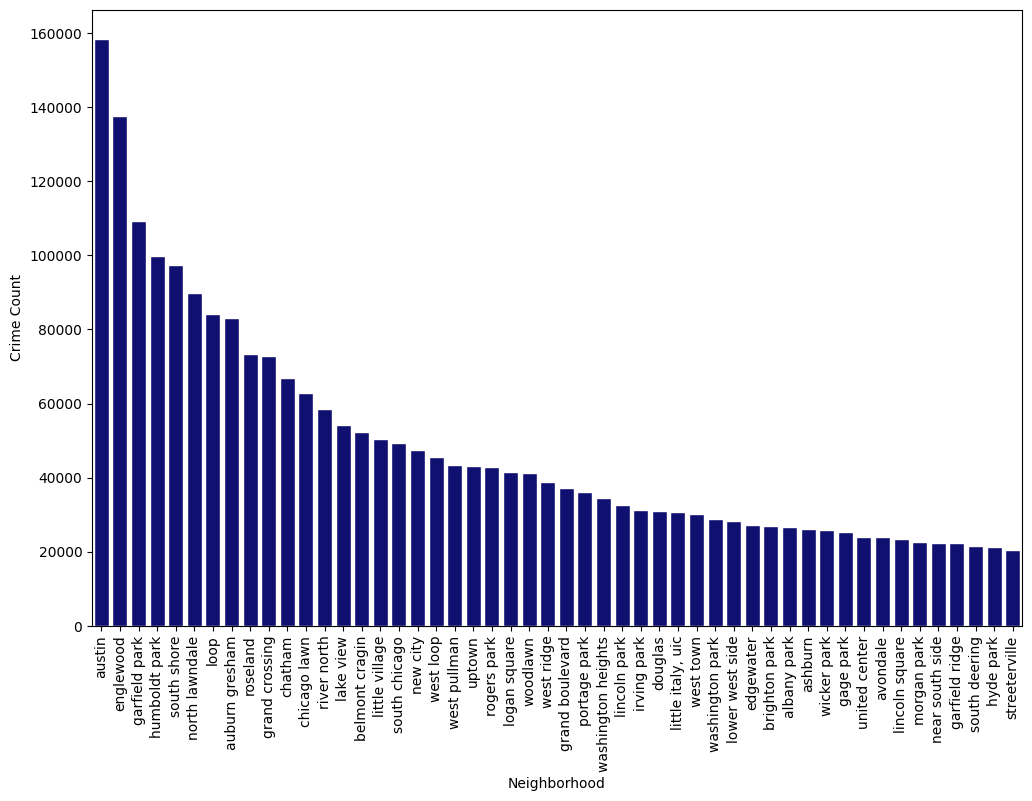

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.set(font_scale=1.)
ax = sns.barplot(x='neighborhood', y='crime_count', data=crime_neigh_stat.iloc[:50], ax=ax, color='navy')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Crime Count')

In [11]:
crime_types = crime_data['primary type'].unique()
print(crime_types)

['theft' 'battery' 'other offense' 'burglary' 'criminal trespass'
 'robbery' 'assault' 'deceptive practice' 'narcotics' 'criminal damage'
 'motor vehicle theft' 'prostitution' 'weapons violation' 'kidnapping'
 'offense involving children' 'sex offense'
 'interference with public officer' 'liquor law violation'
 'criminal sexual assault' 'public peace violation' 'stalking'
 'crim sexual assault' 'homicide' 'arson'
 'concealed carry license violation' 'gambling' 'obscenity'
 'public indecency' 'intimidation' 'human trafficking'
 'other narcotic violation' 'non-criminal' 'ritualism']


In [12]:
# we prompted ChatGPT to spot the dangerous crimes from this list
dangerous_crimes = ['battery', 'robbery', 'assault', 'weapons violation', 'kidnapping', 'offense involving children', 'sex offense', 'criminal sexual assault', 'stalking', 'crim sexual assault', 'homicide', 'arson', 'intimidation']

In [14]:
high_crime_event_neighs = np.array(list(set(high_crime_neighs) & set(high_event_neighs)))

/tmp/ipython-input-171811204.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0, 0.5, 'Event Count')

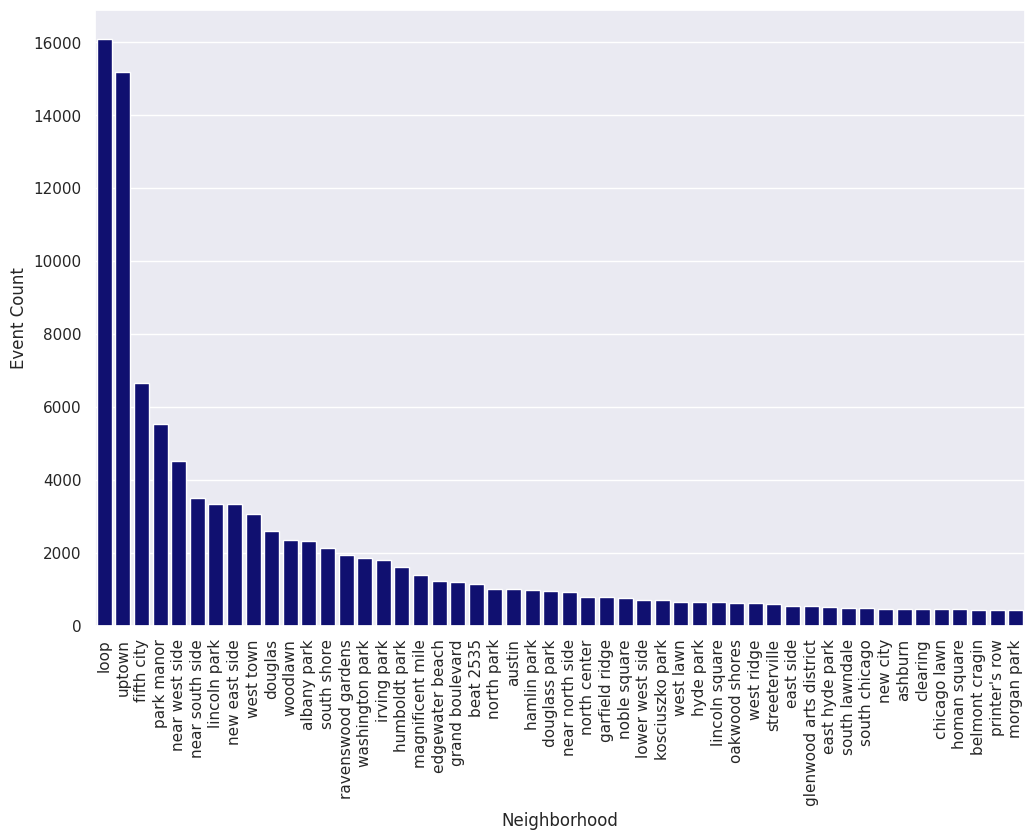

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.set(font_scale=1.)
ax = sns.barplot(x='neighborhood', y='event_count', data=event_neigh_stat.iloc[:50], ax=ax, color='navy')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Event Count')

# Explore Crime and Event Data

In [16]:
crime_data['date'] = pd.to_datetime(crime_data['date'], errors='coerce')
event_data['reservation start date'] = pd.to_datetime(event_data['reservation start date'], errors='coerce')
event_data['reservation end date'] = pd.to_datetime(event_data['reservation end date'], errors='coerce')

In [17]:
high_crime_event_data = event_data[event_data['neighborhood'].isin(high_crime_neighs)]

In [18]:
high_crime_event_neighs

array(['loop', 'humboldt park', 'south shore'], dtype='<U13')

In [19]:
neigh_event_crime_mean = []
for neigh in high_crime_event_neighs:
  event_data_in_neigh = event_data[event_data['neighborhood'] == neigh]
  event_dates = event_data_in_neigh['reservation start date'].unique()

  crimes_in_event_dates = crime_data[(crime_data['date'].isin(event_dates)) & (crime_data['neighborhood'] == neigh)]
  crimes_in_non_event_dates = crime_data[(~crime_data['date'].isin(event_dates)) & (crime_data['neighborhood'] == neigh)]
  num_all_dates = (crime_data['date'].max() - crime_data['date'].min()).days
  num_event_dates = len(event_dates)
  num_non_event_dates = num_all_dates - num_event_dates

  if num_event_dates > 0:
    mean_crime_in_event_dates = len(crimes_in_event_dates) / num_event_dates
    mean_crime_in_non_event_dates = len(crimes_in_non_event_dates) / num_non_event_dates
    neigh_event_crime_mean.append([neigh, mean_crime_in_non_event_dates, mean_crime_in_event_dates])

In [20]:
df = pd.DataFrame(neigh_event_crime_mean, columns=['neighborhood', 'Non-Event Dates', 'Event Dates'])
df_melt = df.melt(id_vars='neighborhood', value_vars=['Non-Event Dates', 'Event Dates'],
                  var_name='kind', value_name='mean_crime')

In [21]:
df

,neighborhood,Non-Event Dates,Event Dates
0,loop,56.191919,0.290710
1,humboldt park,30.409355,0.345455
2,south shore,36.254416,0.550453


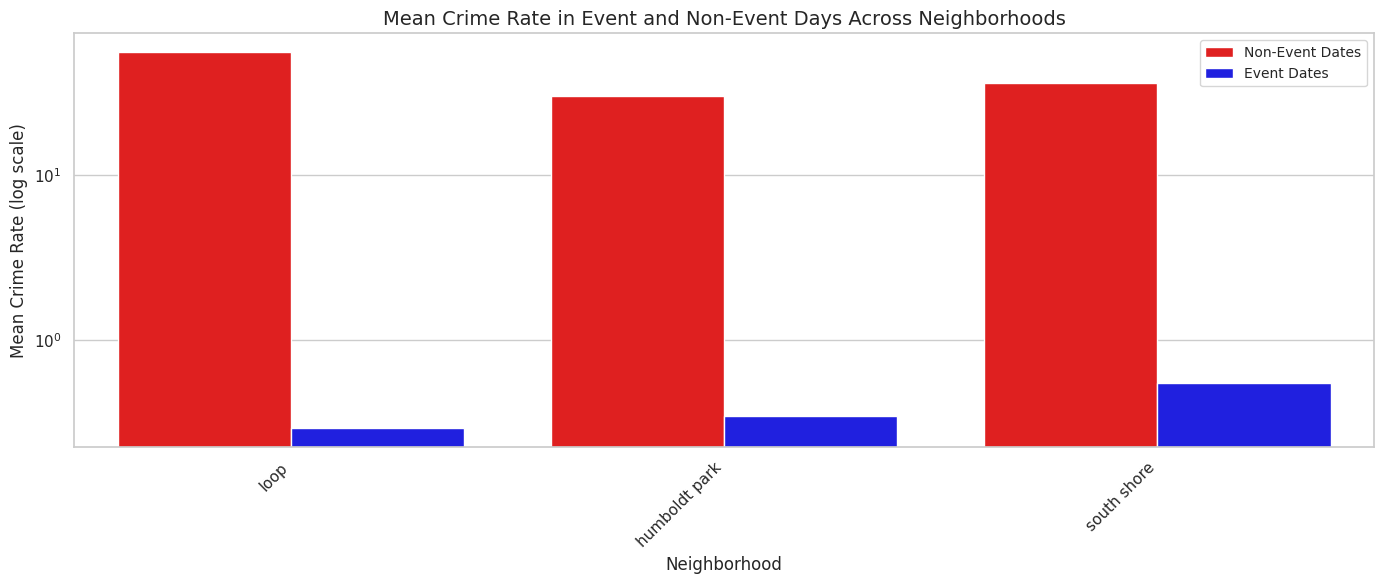

In [22]:
sns.set_theme(style="whitegrid")

# Plot grouped bars with custom colors
plt.figure(figsize=(14, 6))
ax = sns.barplot(x="neighborhood", y="mean_crime", hue="kind", data=df_melt, palette=['red', 'blue'])
ax.set_yscale('log')
plt.xticks(rotation=45, ha='right', fontsize=11)
ax.set_xlabel('Neighborhood', fontsize=12)
ax.set_ylabel('Mean Crime Rate (log scale)', fontsize=12)
ax.set_title('Mean Crime Rate in Event and Non-Event Days Across Neighborhoods', fontsize=14)
plt.legend(title='', fontsize=10)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2727817484.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes[neigh_idx].set_xticklabels(labels=merged['primary type'], rotation=90, ha='right', fontsize=10)
/tmp/ipython-input-2727817484.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes[neigh_idx].set_xticklabels(labels=merged['primary type'], rotation=90, ha='right', fontsize=10)
/tmp/ipython-input-2727817484.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes[neigh_idx].set_xticklabels(labels=merged['primary type'], rotation=90, ha='right', fontsize=10)


Text(0.5, 1.05, 'Percentage of Each Crime In Three Neighborhoods During Event and Non-Event Dates')

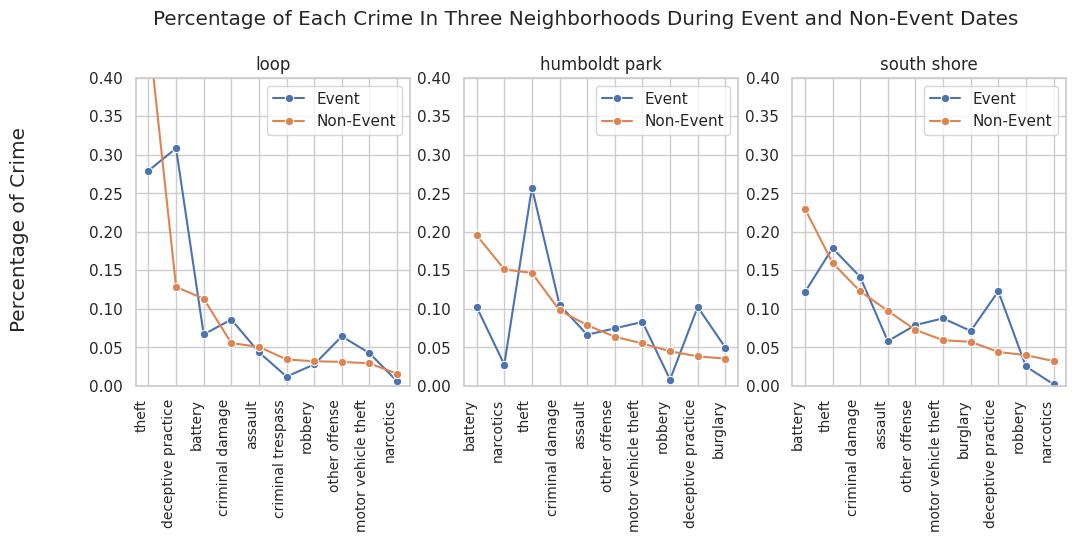

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for neigh_idx, neigh in enumerate(high_crime_event_neighs):

  event_data_in_neigh = event_data[event_data['neighborhood'] == neigh]
  event_dates = event_data_in_neigh['reservation start date'].unique()

  crimes_in_event_dates = crime_data[(crime_data['date'].isin(event_dates)) & (crime_data['neighborhood'] == neigh)]
  crimes_in_non_event_dates = crime_data[(~crime_data['date'].isin(event_dates)) & (crime_data['neighborhood'] == neigh)]

  event_data_in_neigh = event_data[event_data['neighborhood'] == neigh]
  event_dates = event_data_in_neigh['reservation start date'].unique()
  num_all_dates = (crime_data['date'].max() - crime_data['date'].min()).days
  num_event_dates = len(event_dates)
  num_non_event_dates = num_all_dates - num_event_dates


  typical_crimes_non_event_dates = crimes_in_non_event_dates.groupby('primary type').size().reset_index(name='num').sort_values(by='num', ascending=False)
  typical_crimes_event_dates = crimes_in_event_dates.groupby('primary type').size().reset_index(name='num').sort_values(by='num', ascending=False)

  typical_crimes_non_event_dates['crime_perc'] = typical_crimes_non_event_dates['num'] / typical_crimes_non_event_dates['num'].sum()
  typical_crimes_event_dates['crime_perc'] = typical_crimes_event_dates['num'] / typical_crimes_event_dates['num'].sum()

  all_types = list(set(typical_crimes_non_event_dates['primary type']) & set(typical_crimes_event_dates['primary type']))

  final_typical_crimes_event_dates = typical_crimes_event_dates[typical_crimes_event_dates['primary type'].isin(all_types)]
  final_typical_crimes_non_event_dates = typical_crimes_non_event_dates[typical_crimes_non_event_dates['primary type'].isin(all_types)]

  merged = (
      final_typical_crimes_event_dates[['primary type','crime_perc']]
      .merge(final_typical_crimes_non_event_dates[['primary type','crime_perc']], on='primary type', how='inner',
            suffixes=('_event', '_non_event'))
  )
  merged = merged.sort_values(by='crime_perc_non_event', ascending=False)

  sns.lineplot(x=merged['primary type'][:10],
             y=merged['crime_perc_event'][:10],
             marker='o',
             label='Event',
             ax=axes[neigh_idx])
  sns.lineplot(x=merged['primary type'][:10],
              y=merged['crime_perc_non_event'][:10],
              marker='o',
              label='Non-Event',
               ax=axes[neigh_idx])
  _ = axes[neigh_idx].set_xticklabels(labels=merged['primary type'], rotation=90, ha='right', fontsize=10)
  _ = axes[neigh_idx].set_title(neigh)
  axes[neigh_idx].set_xlabel('')
  axes[neigh_idx].set_ylabel('')
  axes[neigh_idx].set_ylim([0., .4])

fig.supylabel('Crime Type')
fig.supylabel('Percentage of Crime')
fig.suptitle('Percentage of Each Crime In Three Neighborhoods During Event and Non-Event Dates', y=1.05)

# Explore Park

## Build a classifier for ratings

In [64]:
lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
stopwords=nltk.corpus.stopwords.words('english')
# Convert part of speech tag from nltk.pos_tag to word net compatible format
def convert_pos_tag(pos):
  if pos[0] in posMapping.keys():
    return posMapping[pos[0]]
  else:
    return 'n'

def remove_puncs(text):
  new_text = ''
  for letter in text:
    if letter in string.punctuation:
      new_text += ' '
    else:
      new_text += letter
  return new_text

# Simple mapping based on first letter of return tag to make grading consistent
# Everything else will be considered noun 'n'
posMapping = {
# "First_Letter by nltk.pos_tag":"POS_for_lemmatizer"
    "N":'n',
    "V":'v',
    "J":'a',
    "R":'r'
}
# 14% credits
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    text = re.sub(r"\'", "", text)
    url_pattern = r'https?://(?:www\.)?[\w.-]+\.[\w]+(?:/[^\s]*)?'
    text = re.sub(url_pattern, ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.lower() # make it lowercase

    text = remove_puncs(text) # removing puncs
    tokens = nltk.word_tokenize(text) # tokenizing text
    # pos_tags = nltk.pos_tag(tokens)
    # tokenized_text = [lemmatizer.lemmatize(pos_tag[0], pos=convert_pos_tag(pos_tag[1])) for pos_tag in pos_tags]
    return ' '.join(tokens)

<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1766991049.py:41: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


In [65]:
X, y = [], []
for park in parks:

  if park['reviews'] == {}:
    continue

  for review in park['reviews']['park_reviews']:
    if review['rating'] > 3:
      y.append(1)
      X.append(process(review['text']))
    elif review['rating'] < 3:
      y.append(0)
      X.append(process(review['text']))

In [66]:
vectorizer = TfidfVectorizer() # define vectorizer
# splitting to train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
# training
X_train_tfidf = vectorizer.fit_transform(X_train)
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_tfidf, y_train)
# prediction
X_test_tfidf = vectorizer.transform(X_test)
preds = clf.predict(X_test_tfidf)
# print report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.55      0.71      0.62        34
           1       0.98      0.95      0.97       438

    accuracy                           0.94       472
   macro avg       0.76      0.83      0.79       472
weighted avg       0.95      0.94      0.94       472



# Explore Train Data

In [53]:
lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
stopwords=nltk.corpus.stopwords.words('english')
# Convert part of speech tag from nltk.pos_tag to word net compatible format
def convert_pos_tag(pos):
  if pos[0] in posMapping.keys():
    return posMapping[pos[0]]
  else:
    return 'n'

def remove_puncs(text):
  new_text = ''
  for letter in text:
    if letter in string.punctuation:
      new_text += ' '
    else:
      new_text += letter
  return new_text

# Simple mapping based on first letter of return tag to make grading consistent
# Everything else will be considered noun 'n'
posMapping = {
# "First_Letter by nltk.pos_tag":"POS_for_lemmatizer"
    "N":'n',
    "V":'v',
    "J":'a',
    "R":'r'
}
# 14% credits
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    text = re.sub(r"\'", "", text)
    url_pattern = r'https?://(?:www\.)?[\w.-]+\.[\w]+(?:/[^\s]*)?'
    text = re.sub(url_pattern, ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.lower() # make it lowercase

    text = remove_puncs(text) # removing puncs
    tokens = nltk.word_tokenize(text) # tokenizing text
    # pos_tags = nltk.pos_tag(tokens)
    # tokenized_text = [lemmatizer.lemmatize(pos_tag[0], pos=convert_pos_tag(pos_tag[1])) for pos_tag in pos_tags]
    return ' '.join(tokens)

<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1766991049.py:41: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


In [55]:
all_station_reviews = [json.loads(reviews) for reviews in station_data['reviews']]
X, y = [], []

for station_reviews in all_station_reviews:

  if station_reviews == {}:
    continue

  for review in station_reviews['station_reviews']:
    if review['rating'] > 3:
      y.append(1)
      X.append(process(review['text']))
    elif review['rating'] < 3:
      y.append(0)
      X.append(process(review['text']))

In [56]:
vectorizer = TfidfVectorizer() # define vectorizer
# splitting to train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
# training
X_train_tfidf = vectorizer.fit_transform(X_train)
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_tfidf, y_train)
# prediction
X_test_tfidf = vectorizer.transform(X_test)
preds = clf.predict(X_test_tfidf)
# print report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61        28
           1       0.88      0.88      0.88        92

    accuracy                           0.82       120
   macro avg       0.74      0.74      0.74       120
weighted avg       0.82      0.82      0.82       120



In [57]:
neigh_station_crimes = {}

for _, station in station_data.iterrows():
  station_reviews = json.loads(station['reviews'])
  neighborhood = str(station['neighborhood'])
  if station_reviews == {} or neighborhood == 'nan':
    continue

  if neighborhood not in neigh_station_crimes.keys():
    neigh_station_crimes[neighborhood] = deepcopy(main_crimes_importances)

  reviews = station_reviews['station_reviews']
  reviews_text = [review['text'] for review in reviews]

  for review_text in reviews_text:

    coefs = clf.coef_[0]
    features = vectorizer.get_feature_names_out()
    X_review = vectorizer.transform([review_text])
    indices = X_review.indices
    values = X_review.data
    words = features[indices]
    # get word importances
    words_importance = values * coefs[indices]

    for word, word_importance in zip(words, words_importance):
      if word in all_crime_words and word_importance < 0:
        if word in reverse_subcrime_2_crime.keys():
          main_crime = reverse_subcrime_2_crime[word]
          neigh_station_crimes[neighborhood][main_crime] += abs(word_importance)


In [58]:
for neigh, crimes in neigh_station_crimes.items():
    for crime in list(crimes.keys()):
        if crimes[crime] == 0:
            del crimes[crime]

filtered_neigh_station_crimes = {k: v for k, v in neigh_station_crimes.items() if v != {}}

In [59]:
def shorten_labels(labels):
  labels = list(labels)
  new_labels = []
  for label in labels:
    if label == 'concealed carry license violation':
      label = 'license-violation'
    elif label == 'public peace violation':
      label = 'peace-violation'
    elif label == 'motor vehicle theft':
      label = 'vehicle-theft'
    new_labels.append(label)
  return new_labels

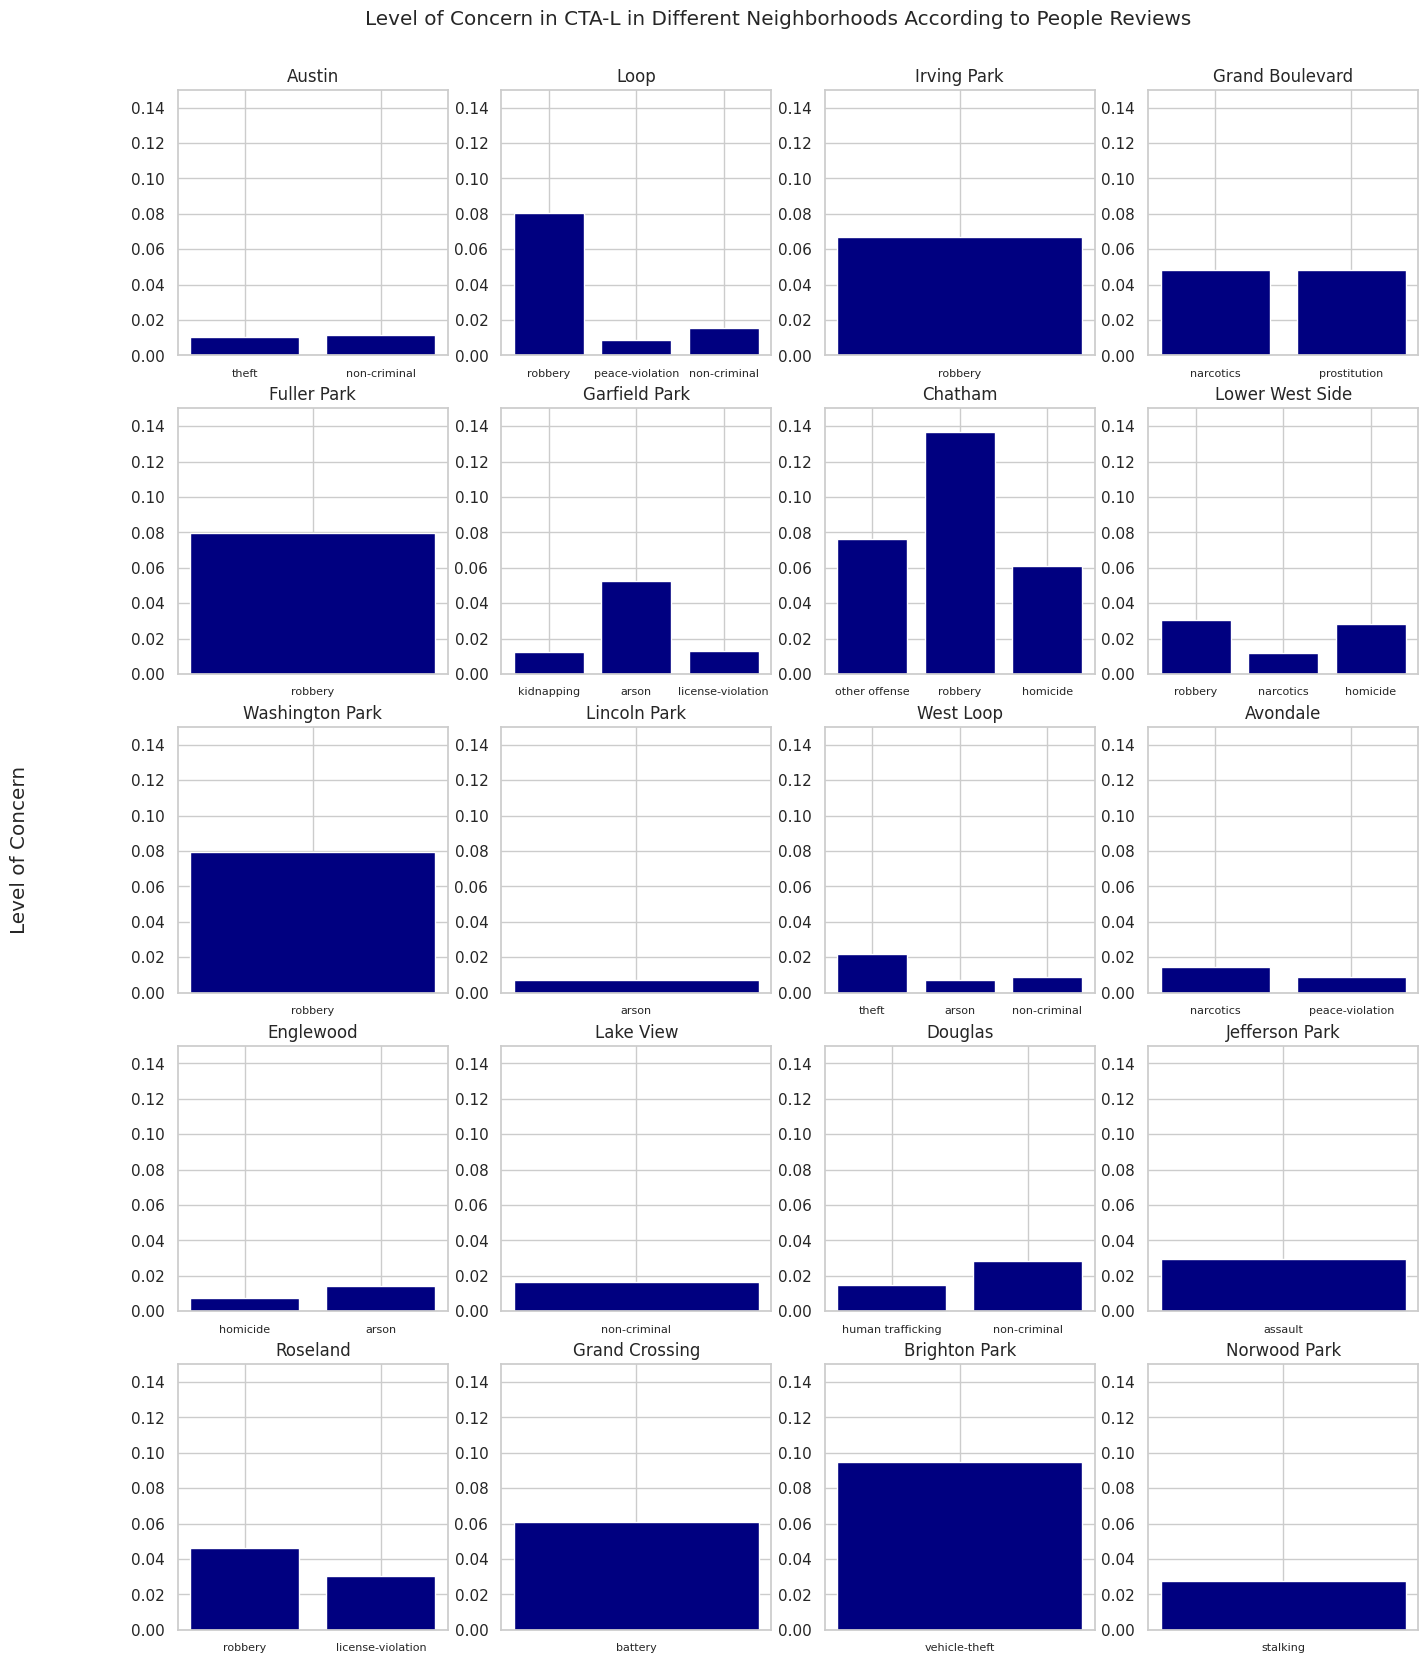

In [60]:
fig, axes = plt.subplots(5, 4, figsize=(16, 20))

for neigh_idx, (k, v) in enumerate(filtered_neigh_station_crimes.items()):
  i, j = neigh_idx // 4, neigh_idx % 4
  axes[i, j].bar(shorten_labels(v.keys()), v.values(), color='navy')
  axes[i, j].set_ylim([0, 0.15])
  axes[i, j].set_title(k)
  axes[i, j].tick_params(axis='x', labelsize=8)

_ = fig.supylabel('Level of Concern')
_ = plt.suptitle('Level of Concern in CTA-L in Different Neighborhoods According to People Reviews', y=.92)